In [1]:
# AIMS Course on Signal Processing

The auto-regressive model of order $p$ is defined as:

$$
\hat{y}[t] = \sum_{i=1}^p a_i y[t - i]
$$

In [48]:
# import packages
using CSV;
using Plots;
using Dates, Statistics, Printf, Distributions;
import LinearAlgebra, Statistics;
pyplot();

In [14]:
data = CSV.read("data.txt");
all_data = data[:, 2:4];

# Direct 1D Solutions

In [321]:
ỹ = all_data[:, 1];

# we have normalised this so that it has unit variance. 
y = (ỹ .- mean(ỹ)) ./ std(ỹ, corrected=false);

function compute_a_embedded(P, y_in)
    # first, we must compute the embedding matrix.
    N = length(y_in);
    target = y_in[P+1:end];
    a = zeros(P);
    N_fit = N - P;
    M = Array{Float64}(undef, N_fit, P)
    for i=1:N_fit
        for j=1:P
            M[i, j] = y_in[P+i-j];
        end
    end
    â = pinv(M) * target;
    x̂ = M * â;
    e = target - x̂;
    return â, M, e
    end;

function compute_a_autocorr(P, y)
    # we need to compute the autocorrelation. Let's do this through estimation. 
    # for an order P model, we need autocorrelations r_xx(0), r_xx(1), ... r_xx(P-1)
    r = Array{Float64}(undef, (P+1))
    
    for i=1:(P+1)
        shift = i-1;
        r[i] = mean(y[1:(length(y)-shift)] .* y[(1+shift): length(y)]);
    end
        
    R = Array{Float64}(undef, P, P);
    for i=1:P
        R[i, i:P] = r[1:(P-i+1)]
    end
    R = Symmetric(R);
    
    a = inv(R) * r[2:length(r)];
        
    return a, R, r;
    end;

In [322]:
a₁, M, e = compute_a_embedded(4, y);

In [323]:
a₂, R, r = compute_a_autocorr(4, y);

In [324]:
a₁

4-element Array{Float64,1}:
  1.5080034613462558 
 -0.643880701719285  
  0.06636192683634068
 -0.04829619377826885

In [329]:
a₂

4-element Array{Float64,1}:
  1.52801867195478    
 -0.6793407778543474  
  0.08720068714467821 
 -0.049717398106609245

# Cross-Regression

In [330]:
function cross_regression(y_ind, z_ind, P)
    ỹ = all_data[:, y_ind];
    # we have normalised this so that it has unit variance. 
    y = (ỹ .- mean(ỹ)) ./ std(ỹ, corrected=false);
    z̃ = all_data[:, z_ind];
    z = (z̃ .- mean(z̃)) ./ std(z̃, corrected=false);
    
    # lets be lazy and use the embedding method.
    N = length(y);
    target = z[P+1:end];
    a = zeros(P);
    N_fit = N - P;
    M = Array{Float64}(undef, N_fit, P)
    for i=1:N_fit
        for j=1:P
            M[i, j] = y[P+i-j];
        end
    end
    â = pinv(M) * target;
    x̂ = M * â;
    e = target - x̂;
    MSE = mean(e .^ 2);
    @printf("MSE %.3f\n", MSE)
    println(â);
    plot(y, show=true, label="output");
    plot!(z, label="input");
    end;

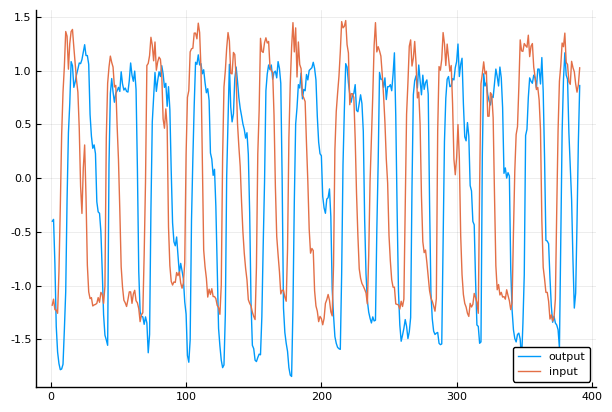

MSE 0.533
[0.6649295656507322, -0.5377334912666545, 0.5498892527550244, -1.0565314783930482]


In [331]:
cross_regression(1, 2, 4);

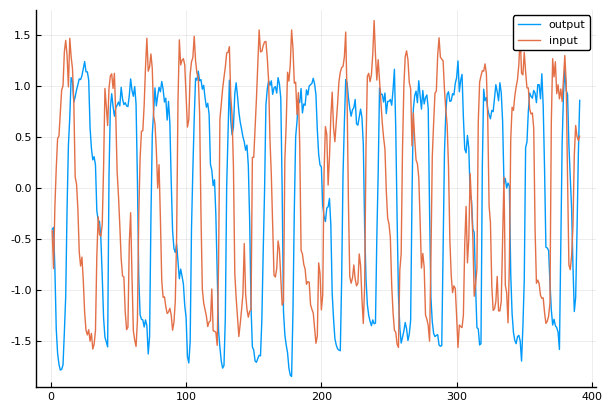

MSE 0.252
[-0.19633176376899533, -0.1546801068556039, 0.4248435879486951, -1.0091791803451309]


In [332]:
cross_regression(1, 3, 4);

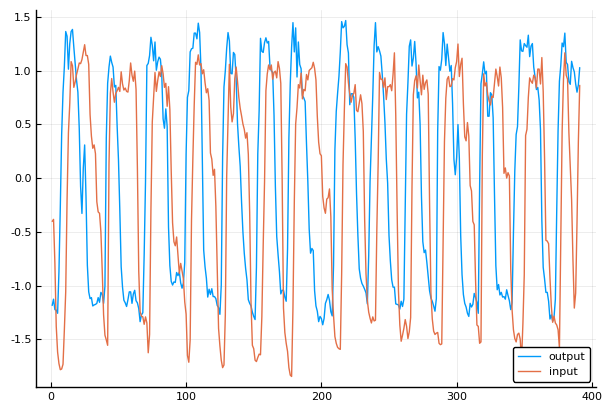

MSE 0.404
[-0.7705853783721, 0.782225263565507, -0.3386741072837101, 0.9302619796264857]


In [333]:
cross_regression(2, 1, 4);

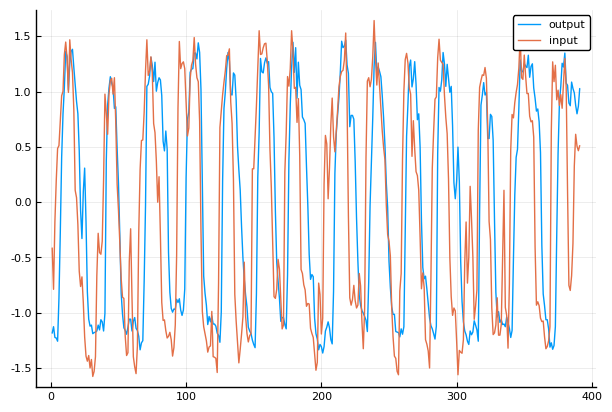

MSE 0.534
[1.2313461306316686, -0.8459772071053338, 0.8748522243584029, -1.0993691082953136]


In [334]:
cross_regression(2, 3, 4);

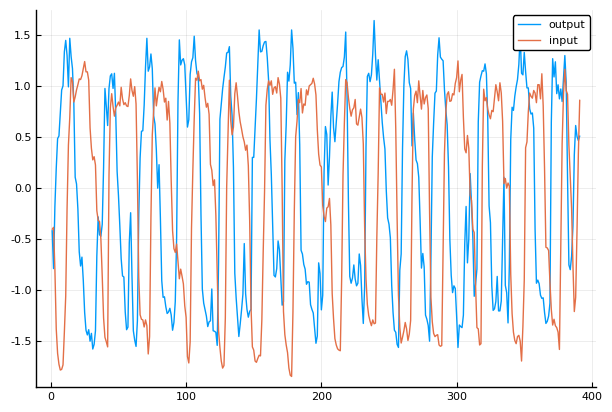

MSE 0.639
[-0.9631391574707941, 0.4725294212354717, -0.257285179029448, 0.6870166745112823]


In [335]:
cross_regression(3, 1, 4);

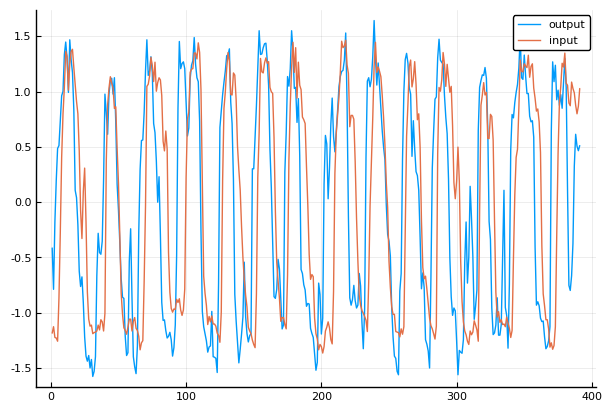

MSE 0.261
[0.11271262557247398, 0.20886710856169144, -0.011747950616019671, 0.6050033706103443]


In [336]:
cross_regression(3, 2, 4);

Comments:

time series 2 and 3 look pretty similar. Time series 1 predicts series 3 well, and time series 3 predicts time series 2 well. 

# Regularisation. 

Lets go to forecasting within time series 1. 

In [435]:
function compute_a_embedded_reg(P, y_in, α)
    # first, we must compute the embedding matrix.
    N = length(y_in);
    target = y_in[P+1:end];
    a = zeros(P);
    N_fit = N - P;
    M = Array{Float64}(undef, N_fit, P)
    for i=1:N_fit
        for j=1:P
            M[i, j] = y_in[P+i-j];
        end
    end
    â = inv(transpose(M)* M + α * I) * transpose(M) *  target;
    x̂ = M * â;
    e = target - x̂;
    plot(1:length(y_in), y_in, label="data");
    extra_vals = zeros(50);
    y_all = Array(y_in)
    append!(y_all, extra_vals);
    println(size(y_all))
    for i=(length(y_in)+1):length(y_all)
       y_all[i] =  sum(y_all[(i-1):-1:(i-P)] .* â);
    end
    
    plot!(y_all, label="predictions", show=true);
    return â, M, e
    end;

ỹ = all_data[:, 1];

# we have normalised this so that it has unit variance. 
y = (ỹ .- mean(ỹ)) ./ std(ỹ, corrected=false);

In [437]:
compute_a_embedded_reg(390, y, 0);

SingularException: SingularException(37)

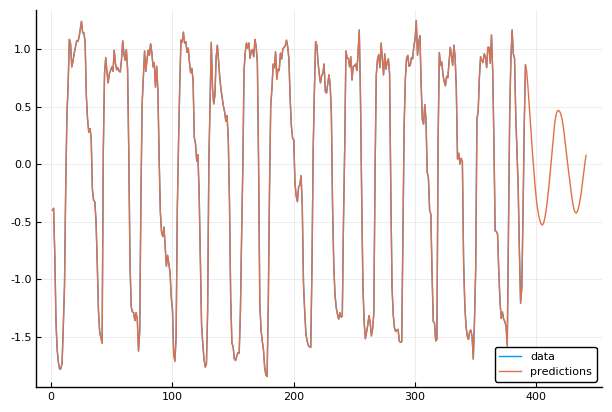

(441,)


In [438]:
compute_a_embedded_reg(390, y, 0.1);

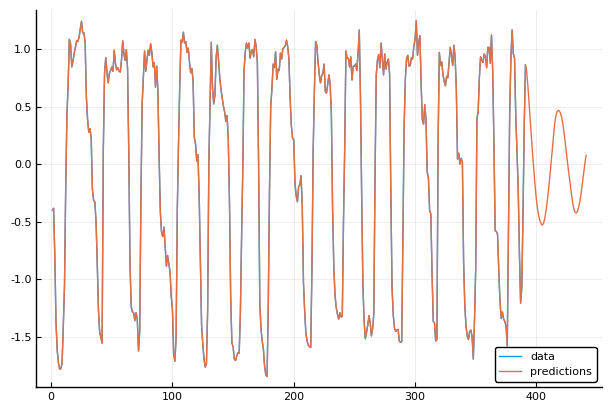

(441,)


In [439]:
compute_a_embedded_reg(390, y, 0.001);

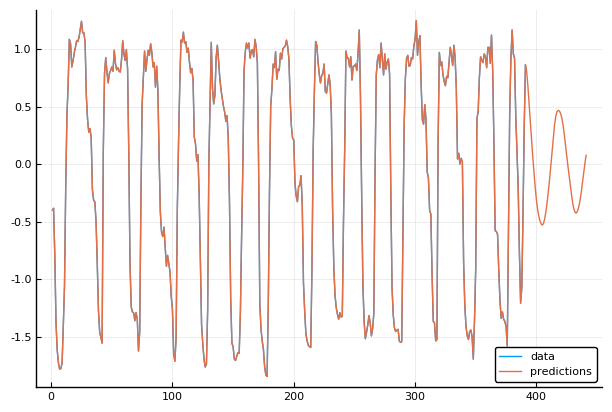

(441,)


In [440]:
compute_a_embedded_reg(390, y, 0.00000001);

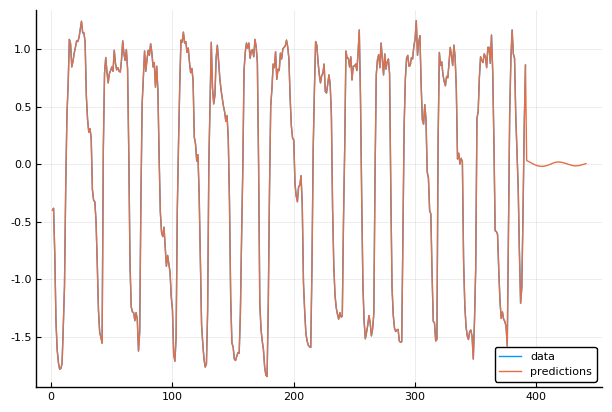

(441,)


In [441]:
compute_a_embedded_reg(390, y, 10000);

In [366]:
y[10:-1:5]

6-element Array{Float64,1}:
 -1.4111148161337816
 -1.732340407162489 
 -1.7764301941664293
 -1.7827287351669923
 -1.7260418661619261
 -1.618966669152357 

In [367]:
y[5:10]

6-element Array{Float64,1}:
 -1.618966669152357 
 -1.7260418661619261
 -1.7827287351669923
 -1.7764301941664293
 -1.732340407162489 
 -1.4111148161337816